### Visualize data from pipeline

`Pipeline.show_results()` is useful for pipeline debugging. This method returns a list of batch data.

In [ ]:
sample_data = pipeline.show_results()

Let's convert the tensor into numpy array and plot the image and mask.

In [7]:
img_batch = sample_data[0]['image'].numpy()
mask_batch = sample_data[0]['annotation'].numpy()

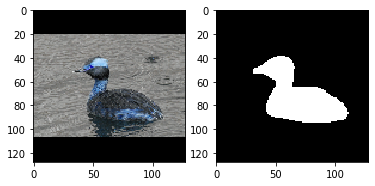

In [8]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(img_batch[0])
axes[1].imshow(np.squeeze(mask_batch[0]), cmap='gray')

In [1]:
from uncertainty_loss_cub200 import get_estimator

In [2]:
estimator = get_estimator(data_path="/home/jenno/data/data")
pipeline = estimator.pipeline

In [3]:
result = pipeline.show_results(num_steps=10)

FastEstimator: Reading non-empty directory: /home/jenno/data/data/CUB200/tfrecords
FastEstimator: Found 4827 examples for train in /home/jenno/data/data/CUB200/tfrecords/train_summary0.json
FastEstimator: Found 1206 examples for eval in /home/jenno/data/data/CUB200/tfrecords/eval_summary0.json


In [21]:
img_batch = result[4]["image"].numpy()
mask = result[4]["annotation"].numpy()

(512, 512, 3)


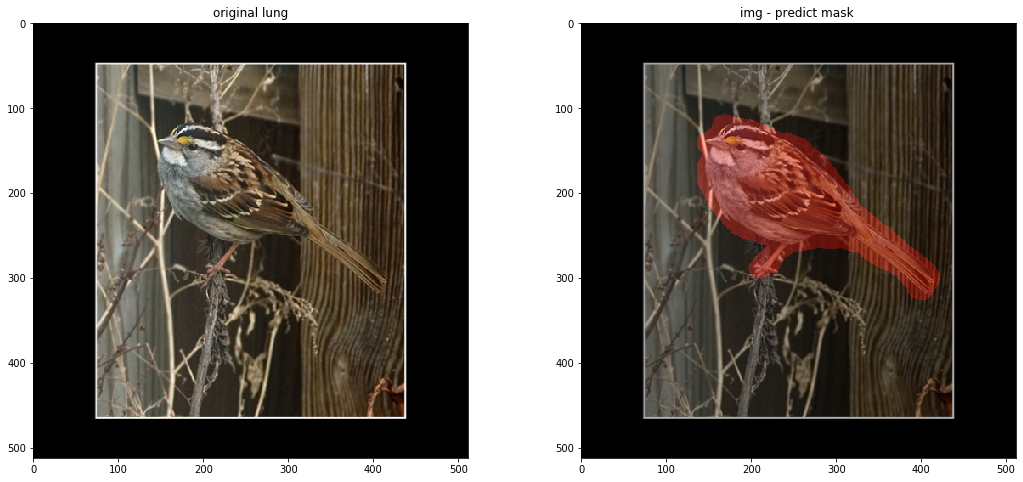

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def Minmax(data):
    data_max = np.max(data)
    data_min = np.min(data)
    data = (data - data_min) / max((data_max - data_min), 1e-7)
    return data


def visualize_image_mask(img, mask):
    img = (img*255).astype(np.uint8)

    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    mask = (mask).astype(np.uint8)

    ret, mask_thres = cv2.threshold(mask, 0.5,1, cv2.THRESH_BINARY)
    print(mask_thres.shape)
    mask_overlay = mask * mask_thres
    mask_overlay = np.where( mask_overlay != [0,0,0], [255,0,0] ,[0,0,0])
    mask_overlay = mask_overlay.astype(np.uint8)
    img_with_mask = cv2.addWeighted(img, 0.7, mask_overlay, 0.3,0 )

    maskgt_with_maskpred = cv2.addWeighted(mask, 0.7, mask_overlay, 0.3, 0)

    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(18,8))
    ax[0].imshow(img)
    ax[0].set_title('original lung')
    ax[1].imshow(img_with_mask)
    ax[1].set_title('img - predict mask ')
    plt.show()




idx = 6

img = Minmax(img_batch[idx])
msk = np.squeeze(mask[idx])

visualize_image_mask(img, msk)

## Create network

First, the `tf.keras.Model` and `tf.optimizers` are put together as `FEModel`.

In [9]:
model = fe.build(model_def=UNet, model_name="unet_cub", optimizer=tf.optimizers.Adam(lr=0.001), loss_name="loss")

Then we combine the `FEModel` and `Loss` together as `Network`.

In [10]:
network = fe.Network(ops=[
    ModelOp(inputs='image', model=model, outputs='mask_pred'),
    BinaryCrossentropy(y_true='annotation', y_pred='mask_pred', outputs="loss")
])

## Create Estimator

`Trace` is similar to callbacks in `tf.keras`. You can specify the metrics you would like to use. In this example we use Dice score. To save your model, you can use the `ModelSaver`. We will save our model in the `save_dir` folder.

In [15]:
save_dir = tempfile.mkdtemp()

In [11]:
traces = [
    Dice(true_key="annotation", pred_key='mask_pred'),
    ModelSaver(model_name="unet_cub", save_dir=save_dir, save_best='dice', save_best_mode='max')
]

After combining everything into `Estimator` we can start training!

In [12]:
estimator = fe.Estimator(network=network, 
                         pipeline=pipeline, 
                         traces=traces, 
                         epochs=epochs, 
                         steps_per_epoch=steps_per_epoch,
                         validation_steps=validation_steps)

## Start traininig

In [ ]:
estimator.fit()

## Inference

In [ ]:
model = load_model(os.path.join(save_dir, 'unet_cub_best_dice.h5'))

In [20]:
predicted_mask = model.predict(img_batch)

Text(0.5, -0.3, 'segmentation mask')

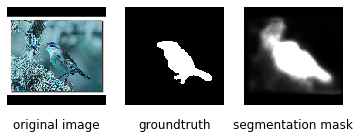

In [41]:
batch_index = 1
fig, axes = plt.subplots(1, 3)
axes[0].imshow(img_batch[batch_index])
axes[0].axis('off')
axes[0].set_title('original image', y=-0.3)
axes[1].imshow(np.squeeze(mask_batch[batch_index]), cmap='gray')
axes[1].axis('off')
axes[1].set_title('groundtruth', y=-0.3)
axes[2].imshow(np.squeeze(predicted_mask[batch_index]), cmap='gray')
axes[2].axis('off')
axes[2].set_title('segmentation mask', y=-0.3)